In [2]:
# Cell 1 — imports & setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10,5)})
sns.set(style="whitegrid")


In [3]:
# Cell 2 — load cleaned dataframes
files = {
    "Benin": "../data/benin_clean.csv",
    "SierraLeone": "../data/sierraleone_clean.csv",
    "Togo": "../data/togo_clean.csv"
}

dfs = {}
for country, path in files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Put cleaned CSV in data/ and re-run.")
    dfs[country] = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=False)
    print(country, "loaded:", dfs[country].shape)

# quick check common columns for metrics
common_cols = set.intersection(*(set(df.columns) for df in dfs.values()))
print("Common columns across datasets:", sorted(common_cols))


Benin loaded: (525600, 27)
SierraLeone loaded: (525600, 26)
Togo loaded: (525600, 26)
Common columns across datasets: ['BP', 'Cleaning', 'DHI', 'DHI_zscore', 'DNI', 'DNI_zscore', 'GHI', 'GHI_zscore', 'ModA', 'ModA_zscore', 'ModB', 'ModB_zscore', 'Precipitation', 'RH', 'TModA', 'TModB', 'Tamb', 'Timestamp', 'WD', 'WDstdev', 'WS', 'WS_zscore', 'WSgust', 'WSgust_zscore', 'WSstdev', 'any_outlier_z3']


In [4]:
# Cell 3 — combine into long format for plotting
metrics = ['GHI','DNI','DHI']
list_parts = []
for country, df in dfs.items():
    # keep Timestamp + metrics if present
    cols = ['Timestamp'] + [m for m in metrics if m in df.columns]
    tmp = df[cols].copy()
    tmp['country'] = country
    list_parts.append(tmp)

combined = pd.concat(list_parts, ignore_index=True)
combined.head()


,Timestamp,GHI,DNI,DHI,country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,Benin


In [ ]:
# Cell 3 — combine into long format for plotting
metrics = ['GHI','DNI','DHI']
list_parts = []
for country, df in dfs.items():
    # keep Timestamp + metrics if present
    cols = ['Timestamp'] + [m for m in metrics if m in df.columns]
    tmp = df[cols].copy()
    tmp['country'] = country
    list_parts.append(tmp)

combined = pd.concat(list_parts, ignore_index=True)
combined.head()


,Timestamp,GHI,DNI,DHI,country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,Benin


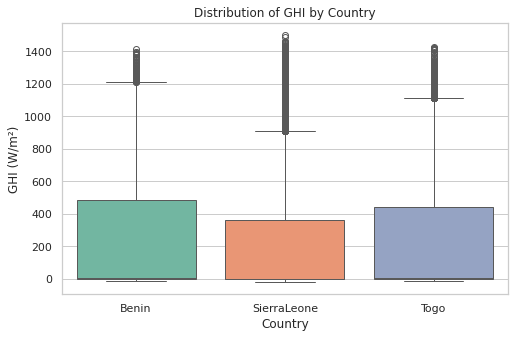

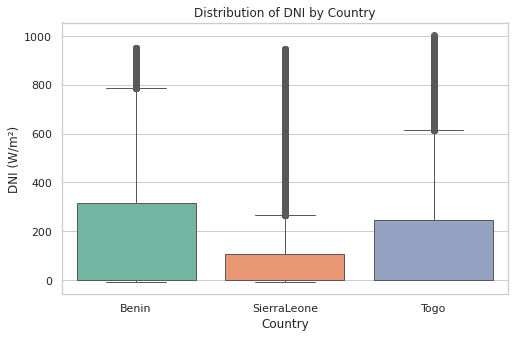

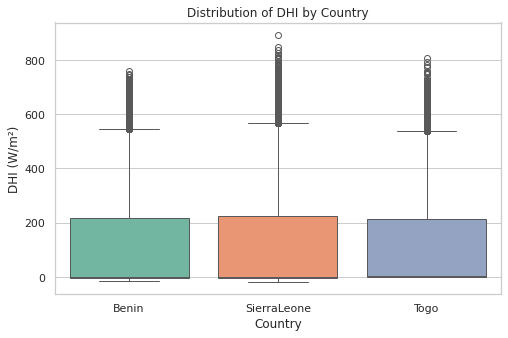

In [11]:
# Cell 4 — boxplots for each metric
for m in metrics:
    if m in combined.columns:
        plt.figure(figsize=(8,5))
        sns.boxplot(x='country', y=m, data=combined, palette='Set2', hue='country', legend=False)
        plt.title(f"Distribution of {m} by Country")
        plt.ylabel(f"{m} (W/m²)")
        plt.xlabel("Country")
        plt.show()
    else:
        print(f"{m} not available in combined dataframe.")


In [7]:
# Cell 5 — summary statistics table
summary_rows = []
for country, df in dfs.items():
    row = {'country': country}
    for m in metrics:
        if m in df.columns:
            row[f'{m}_mean'] = df[m].mean()
            row[f'{m}_median'] = df[m].median()
            row[f'{m}_std'] = df[m].std()
        else:
            row[f'{m}_mean'] = np.nan
            row[f'{m}_median'] = np.nan
            row[f'{m}_std'] = np.nan
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index('country')
display(summary_df.round(2))


,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
country,,,,,,,,,
Benin,240.56,1.8,331.13,167.19,-0.1,261.71,115.36,1.6,158.69
SierraLeone,201.96,0.3,298.50,116.38,-0.1,218.65,113.72,-0.1,158.95
Togo,230.56,2.1,322.53,151.26,0.0,250.96,116.44,2.5,156.52


In [8]:
# Cell 6 — ANOVA & Kruskal-Wallis on GHI
metric = 'GHI'
groups = []
group_names = []
for country, df in dfs.items():
    if metric in df.columns:
        arr = df[metric].dropna().values
        # if extremely large, subsample for speed: use random_state for reproducibility
        if len(arr) > 20000:
            arr = np.random.default_rng(1).choice(arr, size=20000, replace=False)
        groups.append(arr)
        group_names.append(country)

if len(groups) >= 2:
    # Check variance & normality assumptions quickly (optional)
    try:
        f_stat, p_anova = stats.f_oneway(*groups)
        print("One-way ANOVA for", metric)
        print("F-statistic = {:.4f}, p-value = {:.4e}".format(f_stat, p_anova))
    except Exception as e:
        print("ANOVA error:", e)

    # Kruskal-Wallis (nonparametric)
    try:
        h_stat, p_kw = stats.kruskal(*groups)
        print("\nKruskal-Wallis for", metric)
        print("H-statistic = {:.4f}, p-value = {:.4e}".format(h_stat, p_kw))
    except Exception as e:
        print("Kruskal-Wallis error:", e)
else:
    print("Not enough groups for statistical testing.")


One-way ANOVA for GHI
F-statistic = 74.2363, p-value = 6.3011e-33

Kruskal-Wallis for GHI
H-statistic = 174.9924, p-value = 1.0020e-38


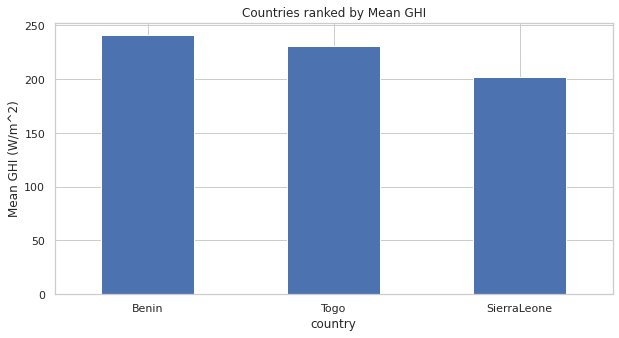

In [9]:
# Cell 7 — ranking by mean GHI
if 'GHI_mean' in summary_df.columns:
    rank = summary_df[['GHI_mean']].dropna().sort_values('GHI_mean', ascending=False)
    ax = rank.plot(kind='bar', legend=False, ylabel='Mean GHI (W/m^2)', title='Countries ranked by Mean GHI')
    plt.xticks(rotation=0)
    plt.show()
else:
    # compute and plot quickly
    means = summary_df['GHI_mean'] if 'GHI_mean' in summary_df.columns else None
    if means is None:
        # fallback: compute from combined
        mean_rank = combined.groupby('country')['GHI'].mean().sort_values(ascending=False)
        mean_rank.plot(kind='bar', ylabel='Mean GHI (W/m^2)', title='Countries ranked by Mean GHI')
        plt.xticks(rotation=0)
        plt.show()
